In [1]:
# This is mostly from https://github.com/microsoft/mutransformers/blob/main/tests/coordcheck/coordcheck.py
from functools import partial
from itertools import cycle

from mup import set_base_shapes, make_base_shapes, get_infshapes
from mup.coord_check import get_coord_data, plot_coord_data
import numpy as np
from transformers import AutoTokenizer

from babylm.models.hf_holo import HFHolo, HFHoloConfig

/Volumes/StrapOn/env/peft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_dataloader(arch):
  if arch == 'holo':
    tokenizer = AutoTokenizer.from_pretrained('gpt2')
    text = "The capital of France is Paris."
    encoded_input = tokenizer(text, return_tensors='pt')
    encoded_input['labels'] = encoded_input['input_ids']
    dataloader = cycle([encoded_input])
  return dataloader

In [3]:

def get_lazy_model(arch, width, hidden_layers=1, base_shape=None, mup=True, readout_zero_init=False, query_zero_init=False, vary_nhead=False):
    width = int(width)
    nhead = 4
    if vary_nhead:
        nhead = int(4 * width / 252)

    def f():
        if arch == 'holo':
            config = HFHoloConfig(
                model_dims=width,
                num_hidden_layers=hidden_layers,
            )
            model = HFHolo(config=config)

        if mup:
            mup_base_shapes = model.mup_base_shapes(
                base_kwargs=dict(num_hidden_layers=hidden_layers),
                delta_kwargs=dict(num_hidden_layers=hidden_layers),
            )
            set_base_shapes(model, mup_base_shapes)
        else:
            set_base_shapes(model, None)

        model.apply(partial(
            model._init_module,
            readout_zero_init=readout_zero_init,
            query_zero_init=query_zero_init,
        ))

        return model

    return f


In [6]:
def plot_coord_check(
    arch, mup=True, vary_nhead=False, y='l1', widths=None, optimizer='adam',
    nseeds=1, nsteps=8, loglog=False, logbase=2, legend=None,
    **get_coord_data_kw
):
    if widths is None:
        widths = 2**np.arange(6, 11)
    models = {width: get_lazy_model(arch, width, mup=mup, vary_nhead=vary_nhead) for width in widths}
    dataloader = get_dataloader(arch)
    df = get_coord_data(models, dataloader, mup=mup, optimizer=optimizer,
                        nseeds=nseeds, dict_in_out=True,
                        nsteps=nsteps, cuda=False, **get_coord_data_kw)
    print(df.sort_values('l1', ascending=False, inplace=False).head(20))
    prm = 'mup' if mup else 'sp'
    width = 'nhead' if vary_nhead else 'dhead'
    return plot_coord_data(df, legend=legend, loglog=loglog, logbase=logbase, y=y,
        save_to=f'{arch}_{prm}_{width}_coord_check.png', suptitle=f'{prm} {arch} {width}',
        face_color='xkcd:light grey' if not mup else None,
       # name_not_contains='out',
        #name_contains='decoder',
        #name_contains='self_attention.',
    )

100%|██████████| 5/5 [00:21<00:00,  4.29s/it]


     width      module  t         l1 optimizer     lr
530   1024  :out[loss]  1  10.824946      adam  0.001
400    512  :out[loss]  1  10.824929      adam  0.001
140    128  :out[loss]  1  10.824924      adam  0.001
270    256  :out[loss]  1  10.824912      adam  0.001
10      64  :out[loss]  1  10.824841      adam  0.001
543   1024  :out[loss]  2  10.824825      adam  0.001
413    512  :out[loss]  2  10.824805      adam  0.001
153    128  :out[loss]  2  10.824796      adam  0.001
283    256  :out[loss]  2  10.824782      adam  0.001
23      64  :out[loss]  2  10.824700      adam  0.001
166    128  :out[loss]  3  10.824673      adam  0.001
556   1024  :out[loss]  3  10.824670      adam  0.001
296    256  :out[loss]  3  10.824650      adam  0.001
426    512  :out[loss]  3  10.824645      adam  0.001
36      64  :out[loss]  3  10.824555      adam  0.001
179    128  :out[loss]  4  10.824551      adam  0.001
309    256  :out[loss]  4  10.824510      adam  0.001
569   1024  :out[loss]  4  1

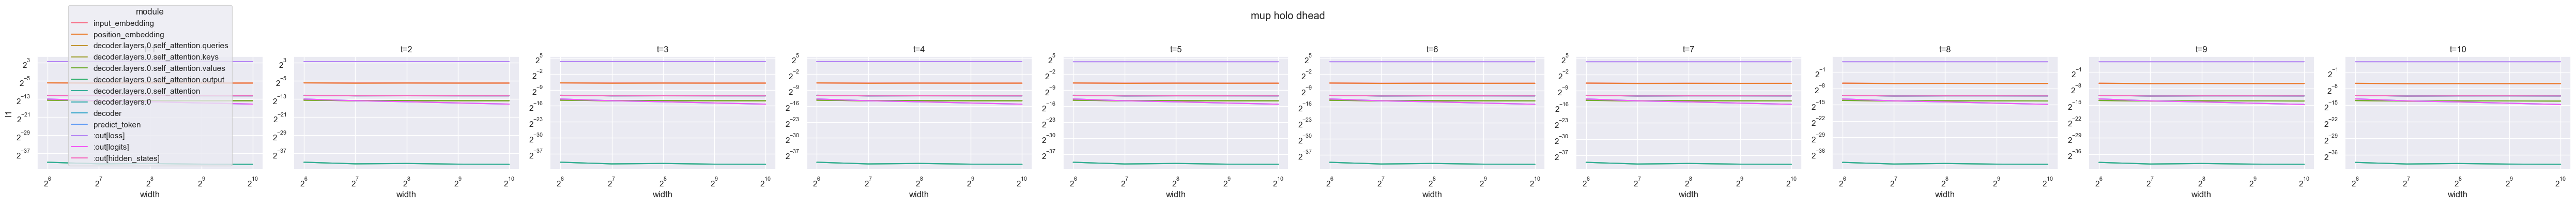

In [7]:
result = plot_coord_check('holo', widths=[64, 128, 256, 512, 1024], lr=0.001, nsteps=10, loglog=True, legend='full', nseeds=1, mup=True)